<a href="https://colab.research.google.com/github/GPhMorin/geneo/blob/main/examples/correlation_mds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlation computation and visualization

This script computes pairwise relationship correlation of the probands from the **genea140** dataset and plots the individuals based on those correlations.

In [144]:
!python --version

Python 3.10.12


The GENEO toolkit will be used for loading the datasets, identifying the probands, and computing the pairwise kinship coefficients.

In [145]:
%pip install umap-learn scikit-bio https://github.com/GPhMorin/geneo/archive/main.zip

  Using cached https://github.com/GPhMorin/geneo/archive/main.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [146]:
import numpy as np
import pandas as pd
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import geneo as gen
from itertools import combinations
from math import factorial
import umap

Two datasets will be used: the **genea140** dataset, which according to the [GENLIB reference manual](https://cran.r-project.org/web/packages/GENLIB/GENLIB.pdf) corresponds to:
> "A genealogical corpus made of 41523 individuals from the province of Quebec, Canada. A total of 140 individuals have been sampled in seven sub-populations, listed in pop140, and their genealogies were reconstructed as far back as possible using the BALSAC population register and the Early Quebec Population Register.

In [44]:
genea140 = gen.genealogy(gen.genea140)
genea140

A pedigree with:
41523 individuals;
68248 parent-child relations;
20773 men;
20750 women;
140 probands;
18 generations.

The other dataset is **pop140** and accompanies **genea140**. According to the GENLIB reference manual:
> The 140 individuals from the genealogical corpus from Quebec were sampled from 7 different populations from 5 regions; Quebec City, Montreal, Saguenay, North Shore, Gaspesia. In Gaspesia we find 3 different populations: French-Canadians, Acadians and Loyalists.

In [45]:
pop140 = pd.read_csv(gen.pop140, sep='\t')
pop140.iloc[:10, :]

,ind,pop
0,409682,Saguenay
1,409687,Saguenay
2,868387,Saguenay
3,717537,Saguenay
4,302711,Saguenay
5,302716,Saguenay
6,868572,Saguenay
7,717634,Saguenay
8,409808,Saguenay
9,718567,Saguenay


Now let's compute the pairwise kinship coefficients. On a recent computer, it should take just a few seconds to run the next line, especially if you have OpenMP detected during the toolkit's installation.

In [46]:
phi = gen.phi(genea140)
phi.iloc[:5, :5]

,217891,218089,219947,288708,288764
217891,0.501290,0.000235,0.005807,0.005166,0.008142
218089,0.000235,0.500118,0.000271,0.000230,0.000230
219947,0.005807,0.000271,0.502834,0.006361,0.007380
288708,0.005166,0.000230,0.006361,0.502508,0.008097
288764,0.008142,0.000230,0.007380,0.008097,0.506433


The pairwise kinship coefficients are then transformed into correlations, where an individual with themself has a correlation of 1 and two unrelated individuals have a correlation of 0.

In [47]:
corr = phi.copy()
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i != j:
            corr.iloc[i, j] = corr.iloc[i, j] / (np.sqrt(phi.iloc[i, i]) * np.sqrt(phi.iloc[j, j]))
for i in range(corr.shape[0]):
    corr.iloc[i, i] = 1
corr.iloc[:5, :5]

,217891,218089,219947,288708,288764
217891,1.000000,0.000470,0.011566,0.010293,0.016159
218089,0.000470,1.000000,0.000540,0.000459,0.000457
219947,0.011566,0.000540,1.000000,0.012654,0.014624
288708,0.010293,0.000459,0.012654,1.000000,0.016052
288764,0.016159,0.000457,0.014624,0.016052,1.000000


In another situation where the genealogies are bigger, you can run `gen.phi(genea140, compute=False)` to get information about the minimum RAM required.

In [48]:
gen.phi(genea140, compute=False)

You will require at least 2.84 GB of RAM.


Let's embed the data into two-dimensional space.

In [147]:
results = pcoa(1 - corr)
emb = results.samples.to_numpy()
emb[:10, :]

array([[-5.18105606e-02,  9.52585285e-02, -1.27600190e-02, ...,
         2.65104218e-03, -1.20825912e-03, -0.00000000e+00],
       [ 3.56952569e-03, -5.88882471e-02,  2.20050785e-02, ...,
         2.17729879e-03, -3.61796461e-04, -0.00000000e+00],
       [-8.67232735e-02,  6.55693182e-02, -2.77563198e-03, ...,
         2.57800453e-03,  9.40230469e-04, -0.00000000e+00],
       ...,
       [-1.19595318e-01,  1.09163640e-01, -6.96378383e-03, ...,
         1.49170941e-04,  1.65735317e-05, -0.00000000e+00],
       [-1.36675030e-01,  1.29893827e-01, -9.70484849e-03, ...,
         7.28436338e-04,  3.22599286e-04, -0.00000000e+00],
       [-1.01432945e-01,  8.40463200e-02, -1.05685540e-03, ...,
         1.61547503e-04, -1.08776409e-04, -0.00000000e+00]])

In [148]:
ratios = results.proportion_explained
ratios

,0
PC1,0.013699
PC2,0.011331
PC3,0.008993
PC4,0.008531
PC5,0.008257
...,...
PC136,0.006397
PC137,0.006293
PC138,0.006169
PC139,0.005533


Probands are identified using the `gen.pro` function.

In [149]:
pro = gen.pro(genea140)
pro[:10]

[217891,
 218089,
 219947,
 288708,
 288764,
 302710,
 302711,
 302716,
 302717,
 302718]

For each proband, we obtain their corresponding population from the **pop140** dataset.

In [150]:
pops = [pop140.loc[pop140['ind'] == ind, 'pop'].iloc[0] for ind in pro]
pops[:10]

['Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay']

For each population, we get the corresponding abbreviation.

In [151]:
population_to_pop = {
    'Gaspesia-Acadian': 'ACA',
    'Gaspesia-FrenchCanadian': 'GFC',
    'Gaspesia-Loyalist': 'LOY',
    'Montreal': 'MON',
    'NorthShore': 'NS',
    'Quebec': 'QUE',
    'Saguenay': 'SAG'
}

For each abbreviation, we get the corresponding color.

In [152]:
pop_to_color = {
    'ACA': 'red',
    'GFC': 'purple',
    'LOY': 'lime',
    'MON': 'orange',
    'NS': 'cyan',
    'QUE': 'blue',
    'SAG': 'darkgreen',
}

Let's extract the color for each proband.

In [153]:
colors = [pop_to_color[population_to_pop[pop]] for pop in pops]
colors[:10]

['darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen']

Finally, let's see the results.

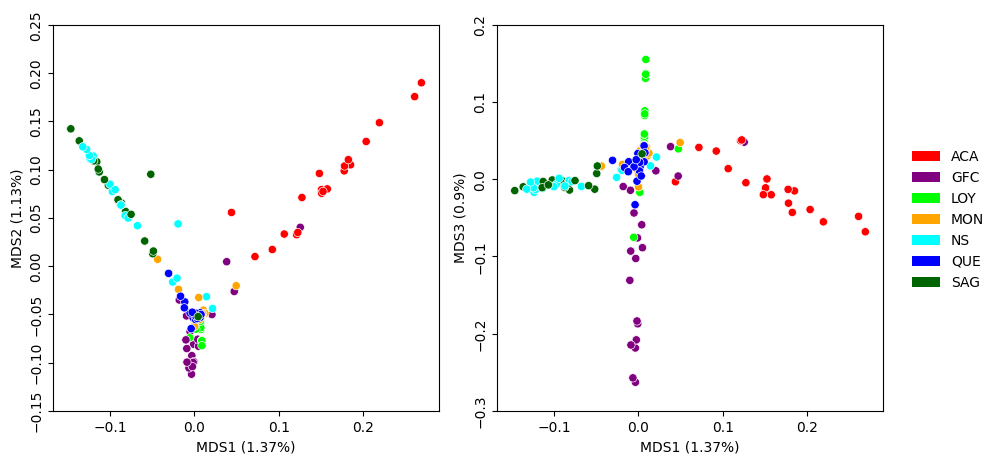

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
left = sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=colors, ax=ax[0],
                     palette={color: color for color in pop_to_color.values()})
left.set_box_aspect(1)
ratio = round(ratios.iloc[0]*100, 2)
left.set_xlabel(f'MDS1 ({ratio}%)')
ratio = round(ratios.iloc[1]*100, 2)
left.set_ylabel(f'MDS2 ({ratio}%)')

# Get the current axis
x0, y0, w, h = left.get_position().bounds

# Rotate the y axis labels
yticks = left.get_yticks()
yticklabels = left.get_yticklabels()
left.set_yticks(yticks, yticklabels, va='center', rotation=90)

# Disable legend for the left side
left.get_legend().remove()


right = sns.scatterplot(x=emb[:, 0], y=emb[:, 2], hue=colors, ax=ax[1],
                     palette={color: color for color in pop_to_color.values()})
right.set_box_aspect(1)
ratio = round(ratios.iloc[0]*100, 2)
right.set_xlabel(f'MDS1 ({ratio}%)')
ratio = round(ratios.iloc[2]*100, 2)
right.set_ylabel(f'MDS3 ({ratio}%)')

# Get the current axis
x0, y0, w, h = left.get_position().bounds

# Rotate the y axis labels
yticks = right.get_yticks()
yticklabels = right.get_yticklabels()
right.set_yticks(yticks, yticklabels, va='center', rotation=90)


# Create a list of legend elements
legend_elements = [Patch(facecolor=color, label=pop)
                   for pop, color in pop_to_color.items()]

# Add the legend to the plot
right.legend(handles=legend_elements, bbox_to_anchor=(x0 / 2 + w * 3.5, y0 + h / 2),
          loc='right', frameon=False)
fig.tight_layout()
plt.show()

The results are comparable to those of the MDS of figure 2 from the article by Roy-Gagnon et al. (2011) <[https://doi.org/10.1007/s00439-010-0945-x]()>.

Let's see if it is possible to see a finer structure.

In [156]:
dist = 1 - corr
dist.replace(1.0, np.nan, inplace=True)
while dist.isnull().sum().sum() > 0:
    null_counts = dist.isnull().sum(axis = 1)
    individuals_to_remove = null_counts[null_counts == null_counts.max()].index
    dist = dist.drop(index=individuals_to_remove)
    dist = dist.drop(columns=individuals_to_remove)
dist.shape

(123, 123)

In [157]:
pops = [pop140.loc[pop140['ind'] == ind, 'pop'].iloc[0] for ind in dist.index]
pops[:10]

['Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay']

In [158]:
results = pcoa(dist)
emb = results.samples.to_numpy()
emb[:10, :]

array([[-4.94645390e-02,  8.94243946e-02, -2.06760851e-02, ...,
        -2.68419860e-03, -1.21480595e-03, -0.00000000e+00],
       [ 3.40975224e-03, -6.56725981e-02,  3.86784310e-02, ...,
        -2.70907698e-03, -4.17461555e-04, -0.00000000e+00],
       [-8.48554976e-02,  6.03973024e-02, -4.67484034e-03, ...,
        -2.65417581e-03,  9.27947593e-04, -0.00000000e+00],
       ...,
       [-1.17095312e-01,  1.05927978e-01, -1.85002050e-02, ...,
        -2.46431080e-04,  8.66976144e-06, -0.00000000e+00],
       [-1.33810828e-01,  1.26593054e-01, -2.31307633e-02, ...,
        -6.16455684e-04,  3.28511444e-04, -0.00000000e+00],
       [-9.93228193e-02,  8.01867660e-02, -7.31324927e-03, ...,
        -2.75414415e-04, -1.21926713e-04, -0.00000000e+00]])

In [159]:
ratios = results.proportion_explained
ratios

,0
PC1,0.015620
PC2,0.012556
PC3,0.009981
PC4,0.009622
PC5,0.009279
...,...
PC119,0.007298
PC120,0.007179
PC121,0.007037
PC122,0.006312


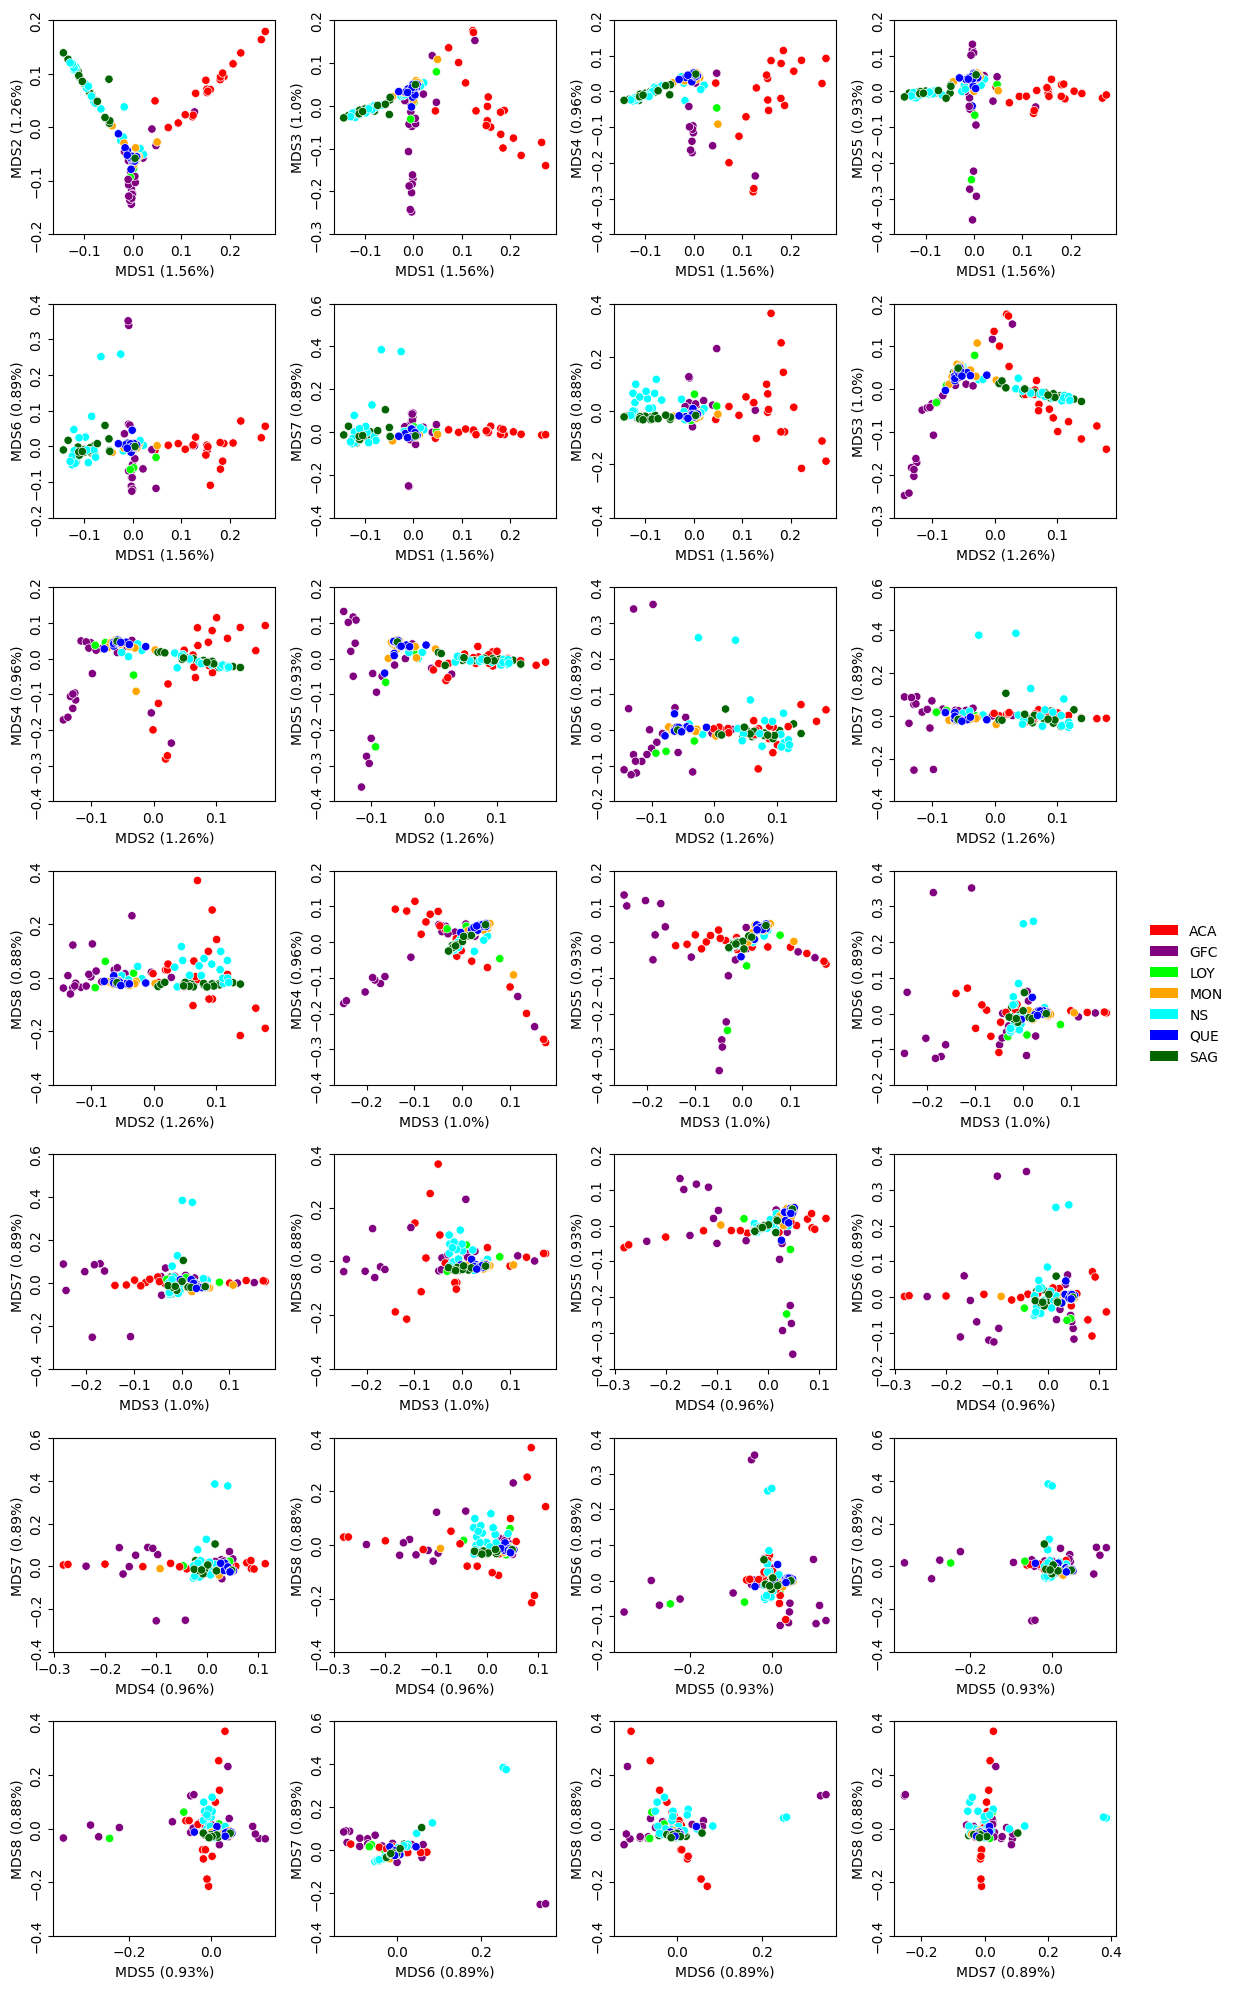

In [160]:
comb = list(combinations(range(8), 2))

rows = len(comb) // 4
cols = 4 + len(comb) % 4
fig, axes = plt.subplots(rows, cols, figsize=(cols/rows * 20, 20))

colors = [pop_to_color[population_to_pop[pop]] for pop in pops]

# Loop through combinations and plot
for index, (i, j) in enumerate(comb):
    ax = axes.flat[index]
    sp = sns.scatterplot(
        x=emb[:, i], y=emb[:, j], hue=colors, ax=ax,
        palette={color: color for color in pop_to_color.values()})
    ratio = round(ratios.iloc[i] * 100, 2)
    ax.set_xlabel(f'MDS{i+1} ({ratio}%)')
    ratio = round(ratios.iloc[j] * 100, 2)
    ax.set_ylabel(f'MDS{j+1} ({ratio}%)')

    # Rotate the y axis labels
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    ax.set_yticks(yticks, yticklabels, va='center', rotation=90)

    # Disable legend
    sp.get_legend().remove()

# Legend outside the plot
legend_handle = fig.legend(handles=legend_elements, bbox_to_anchor=(1.0, 0.5),
                           loc='center left', frameon=False)

plt.tight_layout()
plt.show()

Finally, let's use the first 20 components to visualize a PaCMAP embedding.

In [175]:
X = umap.UMAP(metric='precomputed').fit_transform(dist)
X[:10, :]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


array([[ 2.3980340e-01,  1.0421185e+01],
       [ 4.8017440e+00,  1.0475865e+01],
       [-3.4016293e-01,  1.0891870e+01],
       [-1.7431718e-01,  1.0617272e+01],
       [ 1.4694509e-01,  1.0907563e+01],
       [ 7.9415458e-01,  1.0692356e+01],
       [-6.1257917e-02,  1.1254448e+01],
       [-8.7130647e-03,  1.1178220e+01],
       [ 5.3111777e-02,  1.0413454e+01],
       [ 6.1461723e-01,  1.0838578e+01]], dtype=float32)

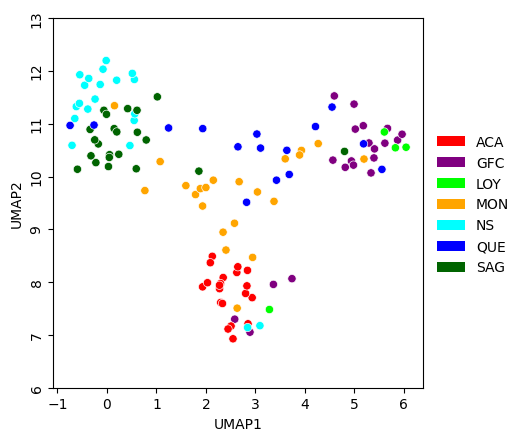

In [176]:
sp = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=colors,
                     palette={color: color for color in pop_to_color.values()})
sp.set_box_aspect(1)
sp.set_xlabel(f'UMAP1')
sp.set_ylabel(f'UMAP2')

# Get the current axis
x0, y0, w, h = sp.get_position().bounds

# Rotate the y axis labels
yticks = sp.get_yticks()
yticklabels = sp.get_yticklabels()
sp.set_yticks(yticks, yticklabels, va='center', rotation=90)

# Create a list of legend elements
legend_elements = [Patch(facecolor=color, label=pop)
                   for pop, color in pop_to_color.items()]

# Add the legend to the plot
sp.legend(handles=legend_elements, bbox_to_anchor=(x0 / 2 + w * 2, y0 + h / 2),
          loc='right', frameon=False)
plt.show()